In [1]:
import pandas as pd
import numpy as np
import OpenBlender
import json
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'OpenBlender'

In [87]:
#pip install OpenBlender

Our aim is to use news data to predict the change in the crypto market, i.e whether the crypto price would rise or whether it would fall

In [68]:
# token is the api_token from the OpenBlender website
token = '61cf23fa9516295c1690ae53HOiaApzCzA9syNcYynvPluwq1qf4Uc'
action = 'API_getObservationsFromDataset'

# using Bitcoin vs USD, which is Daily exchange rate of US dollar vs Bitcoin
parameters = { 
    'token' : token,
    'id_dataset' : '5d4c3af79516290b01c83f51',
    'date_filter':{"start_date" : "2020-05-01",
                   "end_date" : "2021-01-30"} 
}
# reading the json response of the API into pandas dataframe
data = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
data.reset_index(drop=True, inplace=True)
# converting timestamp to date 
data['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in data.timestamp]
data = data.drop('timestamp', axis = 1)

Task ID: '61cf47e40895fafb4a9d8d4b'.
Total estimated consumption: 500.02 processing units.
100.0 % completed.


In [69]:
# generate the target variable which is whether the crypto price increased or declined
# subtracting the closing price and opening price
data['log_diff'] = np.log(data['price']) - np.log(data['open'])

In [70]:
# generate the target variable based on log_diff, if greater than 0, it means rise, if less than 0 it means decline
data['target'] = [1 if log_diff > 0 else 0 for log_diff in data['log_diff']]

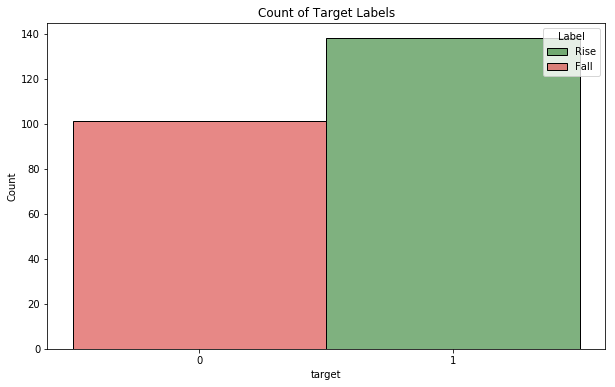

In [71]:
# count of the target variables
plt.subplots(figsize=(10,6))
target_data = data.copy()
target_data["target"]=target_data["target"].astype(str)
plot=sns.histplot(data=target_data,x="target",hue="target",palette=["#d1120f","#006400"],legend="target")
plt.title("Count of Target Labels")
plt.legend(title='Label', loc='upper right', labels=['Rise', 'Fall'])
plt.show(plot)


In [72]:
data.head()

,change,high,low,open,price,volume,date,log_diff,target
0,-6.35%,32519.0,29815.0,32519.0,30454.0,14.77K,27-01-2021 17:00:00,-0.065607,0
1,0.78%,32735.1,31434.0,32268.1,32519.0,8.54K,26-01-2021 17:00:00,0.007745,1
2,-0.09%,34693.0,32268.1,32298.0,32268.1,9.23K,25-01-2021 17:00:00,-0.000926,0
3,0.62%,32830.0,31481.0,32099.0,32298.0,5.89K,24-01-2021 17:00:00,0.006180,1
4,-2.91%,33062.0,31773.0,33062.0,32099.0,7.07K,23-01-2021 17:00:00,-0.029560,0


In [73]:
# mix external news data with our bitcoin data, to do so we will time-blend. 
# In other words, it means to outer join the news dataset using the timestamp as key.
format = '%d-%m-%Y %H:%M:%S'
timezone = 'GMT'

# The Unix Timestamp is the number of seconds since 1970 on UTC 
# it is the preferred format because it is the same in every time zone in the world

data['timestamp'] = OpenBlender.dateToUnix(data['date'], 
                                           date_format = format, 
                                           timezone = timezone)
data = data[['date', 'timestamp', 'price', 'target']]
data.head()

,date,timestamp,price,target
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0


In [74]:
# concat the news dataset with our bitcoin price dataset
# We need to add the id of the dataset and the feature we want from the dataset.
# as the crypto market data is daily based we would aggregrate the news on daily basis 
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text'
            }

# Now, let's 'timeBlend' it to our dataset
data_with_news = OpenBlender.timeBlend( token = token, # API token
                                  anchor_ts = data.timestamp, # our timestamp column,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals', # 'agg_in_intervals' because we want 24 hour interval aggregation
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
data = pd.concat([data, data_with_news.loc[:, data_with_news.columns != 'timestamp']], axis = 1)
data.head()

Task ID: '61cf47e80895fafb4a9d8d4c'.
Total estimated consumption: 1564.8 processing units.
Task confirmed. Starting download..
100%


,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ..."
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community..."


BITCOIN_NE.text_COUNT_last1days shows the number of news on that day

In [75]:
# save our data for the future use
data.to_csv("Input_data.csv", index = False)

In [76]:
# merge our list of news on each day, to one string so that we can tokenize
data["news"] = data["BITCOIN_NE.text_last1days"].apply(lambda x: " ".join(x))

In [77]:
#pip install gensim

In [90]:
# convert our text into vectors using word2vec method, a feature extraction approach
import gensim


tokenized_news = data["news"].apply(lambda x: x.split()) # tokenizing

modelW2v = gensim.models.word2vec.Word2Vec(
            tokenized_news,
            vector_size=200,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 8, # no.of cores
            seed = 34)

modelW2v.train(tokenized_news, total_examples= len(data["news"]), epochs=30)

(564776, 830070)

In [91]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += modelW2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [92]:
wordvec_arrays = np.zeros((len(tokenized_news), 200))

for i in range(len(tokenized_news)):
    wordvec_arrays[i,:] = word_vector(tokenized_news[i], 200)
    
wordvecDf = pd.DataFrame(wordvec_arrays)
wordvecDf.shape 

(239, 200)

In [93]:
columns_list = ["A"+str(i)for i in range(1,201)]
wordvecDf.columns = columns_list

In [94]:
wordvecDf["target"] = data["target"]

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

In [96]:
# splitting data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(wordvecDf,wordvecDf['target'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [97]:
# build a random forest model
random_forest_model = RandomForestClassifier().fit(xtrain, ytrain)
prediction = random_forest_model.predict(xvalid)
print("Accuracy score",accuracy_score(yvalid, prediction))

Accuracy score 0.9861111111111112


In [98]:
# we achieved an accuracy of 98%